In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [3]:
data = pd.read_csv('../input/entity-annotated-corpus/ner_dataset.csv', encoding= 'unicode_escape')
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
data.shape

(1048575, 4)

In [6]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [7]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [8]:

data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,612,14
1,NaN,of,IN,O,4414,14
2,NaN,demonstrators,NNS,O,16306,14
3,NaN,have,VBP,O,4289,14
4,NaN,marched,VBN,O,323,14


In [9]:

data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [10]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[612, 4414, 16306, 4289, 323, 29873, 20275, 20...","[14, 14, 14, 14, 14, 14, 11, 14, 14, 14, 14, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[27134, 30488, 26445, 2533, 17589, 20186, 3462...","[6, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[25126, 884, 31234, 33633, 10261, 5178, 25300,...","[14, 14, 8, 14, 14, 14, 14, 14, 11, 14, 14, 14..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[25219, 31177, 3295, 13269, 18506, 1242, 13003...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[26498, 7455, 7187, 22198, 935, 26016, 20833, ...","[11, 14, 14, 10, 0, 14, 8, 14, 11, 14, 6, 14, ..."


In [11]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [12]:

def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [13]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

25180	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
26445	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
18774	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
14437	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
30307	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
32888	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
20186	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
404	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
10895	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
23607	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9988	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
32214	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2533	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
34345	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
9619	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
24547	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
5605	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
312

In [14]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [15]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [16]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [17]:

def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


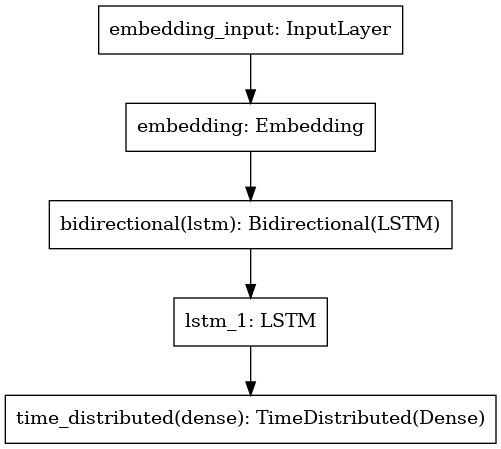

In [18]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [19]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 39s 1s/step - loss: nan - accuracy: 0.0035 - val_loss: nan - val_accuracy: 0.0034


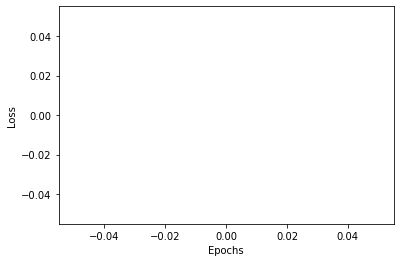

In [20]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [21]:

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [22]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [23]:
for w in text.ents:
    print(w.text, w.label_)

Jim ORG
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
2006]Time CARDINAL
one CARDINAL
two CARDINAL
English NORP
MUC-7 CARDINAL
93.39% PERCENT
97.60% PERCENT


In [24]:

displacy.render(text, style = 'ent', jupyter=True)

In [25]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'